# DoorDash - Delivery Duration Prediction

### Contents
* [Assignment](#Assignment)
* [Data Description](#Data-Description)
* [Data Exploration](#Data-Exploration)
* [Remove Redundant and Collinear Features](#Remove-Redundant-and-Collinear-Features)

### Assignment

When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from

* **Start:** the time consumer submits the order (created_at) to
* **End:** when the order will be delivered to the consumer (actual_delivery_time)

Build a model to predict the total delivery duration seconds (as defined above). Feel free to generate additional features from the given data to improve model performance. Explain:

* model(s) used,
* how you evaluated your model performance on the historical data,
* any data processing you performed on the data,
* feature engineering choices you made,
* other information you would like to share your modeling approach.

### Data Description
The attached file historical_data.csv contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. We have added noise to the dataset to obfuscate certain business details. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds

The target value to predict here is the total seconds value between created_at and actual_delivery_time.

#### Columns in historical_data.csv

* **Time features**

**market_id:** A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id

**created_at:** Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)

**actual_delivery_time:** Timestamp in UTC when the order was delivered to the consumer

* **Store features**

**store_id:** an id representing the restaurant the order was submitted for

**store_primary_category:** cuisine category of the restaurant, e.g., italian, asian

**order_protocol:** a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

* **Order features**

**total_items:** total number of items in the order

**subtotal:** total value of the order submitted (in cents)

**num_distinct_items:** number of distinct items included in the order

**min_item_price:** price of the item with the least cost in the order (in cents)

**max_item_price:** price of the item with the highest cost in the order (in cents)

* **Market features**

DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of created_at (order submission time):

**total_onshift_dashers:** Number of available dashers who are within 10 miles of the store at the time of order creation

**total_busy_dashers:** Subset of above total_onshift_dashers who are currently working on an order

**total_outstanding_orders:** Number of orders within 10 miles of this order that are currently being processed.

* **Predictions from other models**

We have predictions from other models for various stages of delivery process that we can use:

**estimated_order_place_duration:** Estimated time for the restaurant to receive the order from DoorDash (in seconds)

**estimated_store_to_consumer_driving_duration:** Estimated travel time between store and consumer (in seconds)


### Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('historical_data.csv')
data.head(3)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [4]:
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])

# The dt.total_seconds() function is used to return total duration of each element expressed in seconds.
data['actual_total_delivery_duration'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()

data.head(3)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0


In [5]:
data['busy_dashers_ratio'] = data['total_busy_dashers'] / data['total_onshift_dashers']

In [6]:
data['estimated_non_prep_duration'] = data['estimated_store_to_consumer_driving_duration'] + data['estimated_order_place_duration']

In [7]:
data['market_id'].nunique()

6

In [8]:
data['store_id'].nunique()

6743

In [9]:
data['order_protocol'].nunique()

7

In [10]:
order_protocol_dummies = pd.get_dummies(data.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head(3)

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0


In [11]:
market_id_dummies = pd.get_dummies(data.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head(3)

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0


In [12]:
store_id_unique = data['store_id'].unique().tolist()
store_id_and_category = {store_id : data[data.store_id == store_id].store_primary_category.mode()
                        for store_id in store_id_unique}

In [13]:
def fill(store_id):
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan
    
data['nan_free_store_primary_category'] = data.store_id.apply(fill)

In [14]:
store_primary_category_dummies = pd.get_dummies(data.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies.head(3)

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# drop unnecessary columns
train_df = data.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "nan_free_store_primary_category", "order_protocol"])
train_df.head(3)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0


In [16]:
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis =1)

train_df = train_df.astype('float32')
train_df.head(3)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,2.665833,1822.968994,1.629398,522.068542,558.358337,34.524193,32.146065,52.657368,90.211159,219.350143,...,0.028535,0.013687,0.073625,0.105705,0.027175,0.189502,0.034246,0.037816,0.064904,0.173167
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
train_df['busy_dashers_ratio'].describe()

count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

In [19]:
# Check infinity values with using numpy isfinite() function
np.where(np.any(~np.isfinite(train_df), axis = 0) == True)

(array([ 5,  6,  7,  9, 10, 11, 12]),)

In [20]:
train_df.replace([np.inf, -np.inf], np.nan, inplace = True)

train_df.dropna(inplace = True)

In [21]:
train_df.shape

(177070, 100)

### Remove Redundant and Collinear Features

<Axes: >

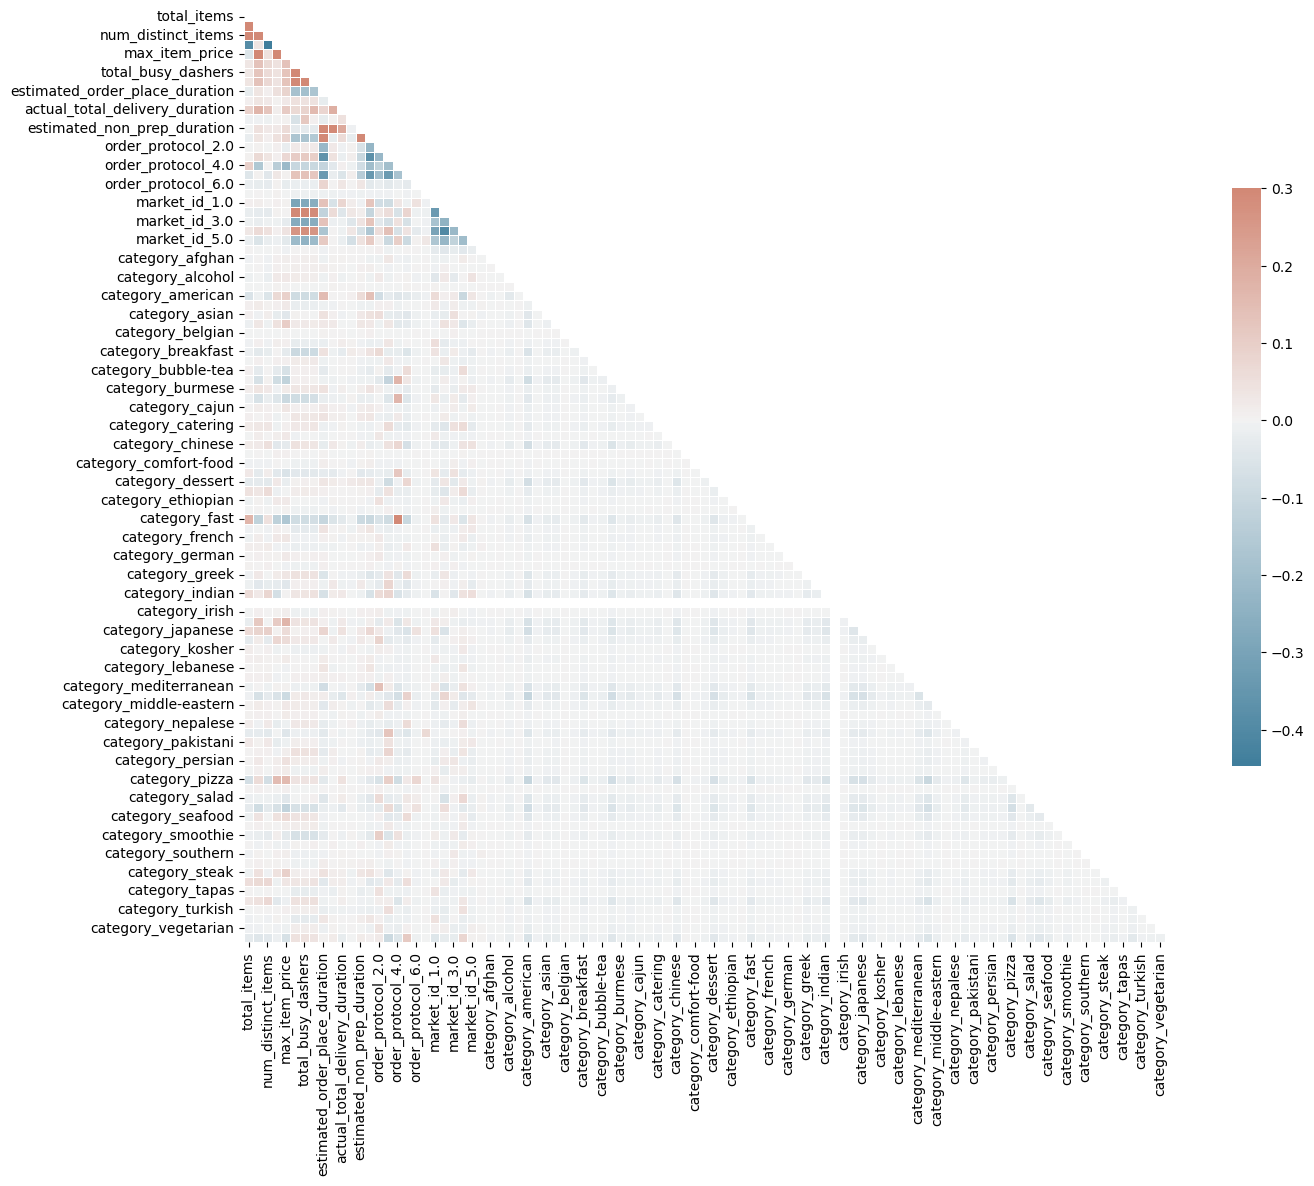

In [31]:
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

f, ax = plt.subplots(figsize = (15,15))

cmap = sns.diverging_palette(230, 20, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 0.3, center = 0,
           square = True, linewidth = 0.5, cbar_kws = {"shrink" : 0.5})

In [32]:
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64